<a href="https://colab.research.google.com/github/jvallalta/monai/blob/main/Ejemplo_clasificacion_MONAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capacitación y validación de modelos de extremo a extremo con Pytorch, Ignite y MONAI

## Visión general
Este cuaderno lo lleva a través del flujo de trabajo de un extremo a otro utilizando para entrenar un modelo de aprendizaje profundo. Harás lo siguiente:

- Descargue el conjunto de datos de MedNIST
-Explore los datos
-Preparar conjuntos de datos de entrenamiento, validación y prueba
-Utilice transformaciones, conjuntos de datos y cargador de datos de MONAI
-Definir la función de red, optimizador y pérdida
-Entrena tu modelo con un ciclo de entrenamiento estándar de pytorch
-Traza tus métricas de entrenamiento
-Evalúe su modelo en un conjunto de prueba
-Entiende tus resultados
-Haz algunas mejoras
  - Vuelva a visitar el entrenamiento de modelos con las funciones de encendido y MONAI
  - Solucionar problemas que limitan la reproducibilidad
  - Rehacer la partición de conjuntos de datos

# Importa todo lo que necesitaremos de MONAI
Importaciones iniciales de los distintos paquetes utilizados para crear un modelo utilizando pytorch y MONAI.

In [1]:
!pip install -qU "monai[ignite]==0.3.0rc2"

%matplotlib inline

import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import PIL

import torch

import monai

from monai.apps import download_and_extract
from monai.config import print_config
from monai.metrics import compute_roc_auc
from monai.networks.nets import densenet121
from monai.transforms import (
    AddChannel,
    Compose,
    LoadPNG,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
    ToTensor,
)
from monai.utils import set_determinism

print_config()

     |████████████████████████████████| 290 kB 7.8 MB/s 
     |████████████████████████████████| 103 kB 15.7 MB/s 
MONAI version: 0.3.0rc2
Python version: 3.7.11 (default, Jul  3 2021, 18:01:19)  [GCC 7.5.0]
Numpy version: 1.19.5
Pytorch version: 1.9.0+cu102

Optional dependencies:
Pytorch Ignite version: 0.3.0
Nibabel version: 3.0.2
scikit-image version: 0.16.2
Pillow version: 7.1.2
Tensorboard version: 2.5.0
gdown version: 3.6.4
TorchVision version: 0.10.0+cu102
ITK version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



# Configurar directorio de datos
Crearemos un directorio temporal para todos los datos MONAI que usaremos llamado MONAI_DATA_DIRECTORY.

In [2]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmpkhfee7k2


# Descargue el conjunto de datos de MedNIST
El conjunto de datos de MedNIST se obtuvo de varios conjuntos de TCIA, el RSNA Bone Age Challenge y el conjunto de datos de rayos X de tórax de los NIH.

El conjunto de datos fue proporcionado amablemente por el Dr. Bradley J. Erickson M.D., Ph.D. (Departamento de Radiología, Clínica Mayo) bajo la licencia Creative Commons CC BY-SA 4.0.

Si utiliza el conjunto de datos de MedNIST, reconozca la fuente.

Vamos a descargar este conjunto de datos a continuación y extraerlo en nuestro directorio de datos MONAI temporal.

In [3]:

resource = "https://www.dropbox.com/s/5wwskxctvcxiuea/MedNIST.tar.gz?dl=1"
md5 = "0bc7306e7427e00ad1c5526a6677552d"

compressed_file = os.path.join(root_dir, "MedNIST.tar.gz")
data_dir = os.path.join(root_dir, "MedNIST")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

61841408/61834679 Downloading MedNIST.tar.gz: [==============================]
downloaded file: /tmp/tmpkhfee7k2/MedNIST.tar.gz.
Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.


# Establecer entrenamiento determinista para la reproducibilidad
*set_determinism* establecerá las semillas aleatorias tanto en Numpy como en PyTorch para garantizar la reproducibilidad. Veremos más adelante que tenemos que ir un poco más allá para garantizar la reproducibilidad en un portátil jupyter.

In [4]:

set_determinism(seed=0)

# Leer los nombres de archivo de imagen de las carpetas del conjunto de datos
Al usar un conjunto de datos, desea comprender los conceptos básicos de las imágenes, etiquetas y más. Comenzaremos mostrando algunas de esas estadísticas básicas para MedNIST.

Veremos que 6 carpetas diferentes representan 6 categorías diferentes: Mano, AbdomenCT, CXR, ChestCT, BreastMRI, HeadCT. Usaremos cada una de estas categorías como los nombres de nuestras etiquetas.

In [5]:
class_names = sorted(x for x in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, x)))
num_class = len(class_names)
image_files = [
    [
        os.path.join(data_dir, class_names[i], x)
        for x in os.listdir(os.path.join(data_dir, class_names[i]))
    ]
    for i in range(num_class)
]
num_each = [len(image_files[i]) for i in range(num_class)]
image_files_list = []
image_class = []
for i in range(num_class):
    image_files_list.extend(image_files[i])
    image_class.extend([i] * num_each[i])
num_total = len(image_class)
image_width, image_height = PIL.Image.open(image_files_list[0]).size

print(f"Total image count: {num_total}")
print(f"Image dimensions: {image_width} x {image_height}")
print(f"Label names: {class_names}")
print(f"Label counts: {num_each}")

Total image count: 58954
Image dimensions: 64 x 64
Label names: ['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']
Label counts: [10000, 8954, 10000, 10000, 10000, 10000]


# Elija imágenes al azar del conjunto de datos para visualizarlas y verificarlas.
Queremos entender cómo se ven las imágenes que estamos usando, así que comenzaremos visualizando algunas imágenes aleatorias.

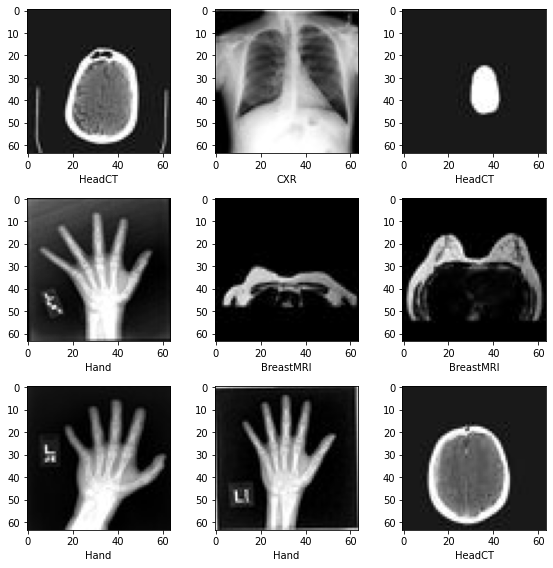

In [7]:
plt.subplots(3, 3, figsize=(8, 8))
for i, k in enumerate(np.random.randint(num_total, size=9)):
    im = PIL.Image.open(image_files_list[k])
    arr = np.array(im)
    plt.subplot(3, 3, i + 1)
    plt.xlabel(class_names[image_class[k]])
    plt.imshow(arr, cmap="gray", vmin=0, vmax=255)
plt.tight_layout()
plt.show()

# Preparar listas de datos de prueba, validación y entrenamiento
Queremos dividir los datos en 3 conjuntos diferentes, uno para entrenamiento, otro para validación y otro para pruebas. Usaremos una proporción de 80/10/10 para esos conjuntos.

In [8]:
val_frac = 0.1
test_frac = 0.1
train_x = list()
train_y = list()
val_x = list()
val_y = list()
test_x = list()
test_y = list()

for i in range(num_total):
    rann = np.random.random()
    if rann < val_frac:
        val_x.append(image_files_list[i])
        val_y.append(image_class[i])
    elif rann < test_frac + val_frac:
        test_x.append(image_files_list[i])
        test_y.append(image_class[i])
    else:
        train_x.append(image_files_list[i])
        train_y.append(image_class[i])

print(f"Training count: {len(train_x)}, Validation count: {len(val_x)}, Test count: {len(test_x)}")

Training count: 46944, Validation count: 6023, Test count: 5987


# Definir transformaciones MONAI, conjunto de datos y cargador de datos para preprocesar datos
Definiremos nuestra transformación usando Compose. En esta matriz de transformaciones, cargaremos la imagen, agregaremos un canal, escalaremos su intensidad, utilizaremos algunas funciones aleatorias y finalmente crearemos un tensor.

In [9]:

train_transforms = Compose(
    [
        LoadPNG(image_only=True),
        AddChannel(),
        ScaleIntensity(),
        RandRotate(range_x=15, prob=0.5, keep_size=True),
        RandFlip(spatial_axis=0, prob=0.5),
        RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
        ToTensor(),
    ]
)

val_transforms = Compose([LoadPNG(image_only=True), AddChannel(), ScaleIntensity(), ToTensor()])

# Inicialice los conjuntos de datos y los cargadores para el entrenamiento, la validación y los conjuntos de pruebas.
Defina un conjunto de datos simple, que llamaremos MedNISTDataset, que agrupa:
- Imagenes
- Etiquetas
- Las transformaciones que se ejecutarán en las imágenes y etiquetas.

Cree tres instancias de este conjunto de datos:
- Uno para entrenar
- Uno para validación
- Uno para probar

Usaremos un tamaño de lote de 512 y emplearemos a 10 trabajadores para cargar los datos.

In [10]:
batch_size = 512
num_workers = 2

class MedNISTDataset(torch.utils.data.Dataset):
    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]


train_ds = MedNISTDataset(train_x, train_y, train_transforms)
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers)

val_ds = MedNISTDataset(val_x, val_y, val_transforms)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=batch_size, num_workers=num_workers)

test_ds = MedNISTDataset(test_x, test_y, val_transforms)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, num_workers=num_workers)

# Definir red y optimizador
Establezca learning_rate para cuánto se actualiza el modelo por paso
La búsqueda de un dispositivo Pytorch para la GPU.
Cree una instancia de modelo densenet121 y 'envíela' a la GPU usando el dispositivo
Esta es una implementación estándar de MONAI; es capaz de operar en 2D y 3D pero aquí lo estamos usando en modo 2D
Usaremos el optimizador de Adam

In [11]:
learning_rate = 1e-5
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = densenet121(spatial_dims=2, in_channels=1, out_channels=num_class).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), learning_rate)

# Entrenamiento en red
Estamos haciendo un ciclo de entrenamiento básico de pytorch aquí:

bucle de entrenamiento pytorch estándar
paso a través de cada época de entrenamiento, ejecutando el conjunto de entrenamiento en lotes
después de cada época, ejecute un pase de validación, evaluando la red
si muestra un rendimiento mejorado, guarde los pesos del modelo
más adelante volveremos a visitar los bucles de entrenamiento de una manera más Ignite / MONAI

In [12]:

epoch_num = 4
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = list()
metric_values = list()

for epoch in range(epoch_num):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{epoch_num}")

    epoch_loss = 0
    step = 1

    steps_per_epoch = len(train_ds) // train_loader.batch_size

    # put the network in train mode; this tells the network and its modules to
    # enable training elements such as normalisation and dropout, where applicable
    net.train()
    for batch_data in train_loader:

        # move the data to the GPU
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)

        # prepare the gradients for this step's back propagation
        optimizer.zero_grad()
        
        # run the network forwards
        outputs = net(inputs)
        
        # run the loss function on the outputs
        loss = loss_function(outputs, labels)
        
        # compute the gradients
        loss.backward()
        
        # tell the optimizer to update the weights according to the gradients
        # and its internal optimisation strategy
        optimizer.step()

        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size + 1}, training_loss: {loss.item():.4f}")
        step += 1

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    # after each epoch, run our metrics to evaluate it, and, if they are an improvement,
    # save the model out
    
    # switch off training features of the network for this pass
    net.eval()

    # 'with torch.no_grad()' switches off gradient calculation for the scope of its context
    with torch.no_grad():
        # create lists to which we will concatenate the the validation results
        images = list()
        labels = list()

        # iterate over each batch of images and run them through the network in evaluation mode
        for val_data in val_loader:
            val_images, val_labels = val_data[0].to(device), val_data[1].to(device)

            # run the network
            val_pred = net(val_images)

            images.append(val_pred)
            labels.append(val_labels)

        # concatenate the predicted labels with each other and the actual labels with each other
        y_pred = torch.cat(images)
        y = torch.cat(labels)

        # we are using the area under the receiver operating characteristic (ROC) curve to determine
        # whether this epoch has improved the best performance of the network so far, in which case
        # we save the network in this state
        auc_metric = compute_roc_auc(y_pred, y, to_onehot_y=True, softmax=True)
        metric_values.append(auc_metric)
        acc_value = torch.eq(y_pred.argmax(dim=1), y)
        acc_metric = acc_value.sum().item() / len(acc_value)
        if auc_metric > best_metric:
            best_metric = auc_metric
            best_metric_epoch = epoch + 1
            torch.save(net.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
            print("saved new best metric network")
        print(
            f"current epoch: {epoch + 1} current AUC: {auc_metric:.4f} /"
            f" current accuracy: {acc_metric:.4f} best AUC: {best_metric:.4f} /"
            f" at epoch: {best_metric_epoch}"
        )

print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")

----------
epoch 1/4


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


1/92, training_loss: 1.7904
2/92, training_loss: 1.7520
3/92, training_loss: 1.7402
4/92, training_loss: 1.7070
5/92, training_loss: 1.6826
6/92, training_loss: 1.6672
7/92, training_loss: 1.6356
8/92, training_loss: 1.6101
9/92, training_loss: 1.5859
10/92, training_loss: 1.5611
11/92, training_loss: 1.5360
12/92, training_loss: 1.5214
13/92, training_loss: 1.5029
14/92, training_loss: 1.4817
15/92, training_loss: 1.4558
16/92, training_loss: 1.4172
17/92, training_loss: 1.4210
18/92, training_loss: 1.3990
19/92, training_loss: 1.3889
20/92, training_loss: 1.3578
21/92, training_loss: 1.3235
22/92, training_loss: 1.3177
23/92, training_loss: 1.2900
24/92, training_loss: 1.2742
25/92, training_loss: 1.2606
26/92, training_loss: 1.2546
27/92, training_loss: 1.2227
28/92, training_loss: 1.2117
29/92, training_loss: 1.2167
30/92, training_loss: 1.1831
31/92, training_loss: 1.1593
32/92, training_loss: 1.1372
33/92, training_loss: 1.1590
34/92, training_loss: 1.1105
35/92, training_loss: 1

# Trace la pérdida y la métrica
Una vez que terminamos el entrenamiento, queremos visualizar nuestra Pérdida y Precisión.

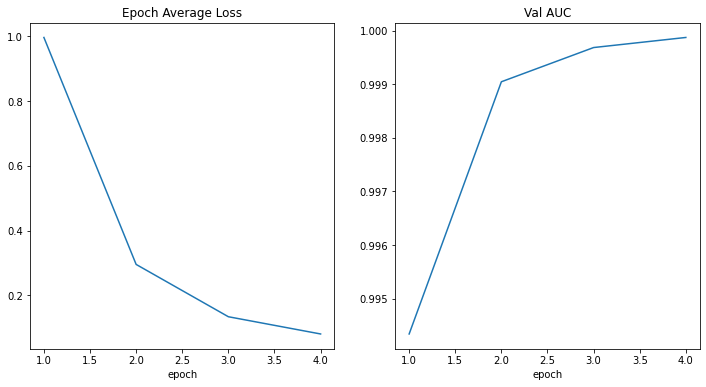

In [13]:

plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [(i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

In [14]:

net.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
net.eval()
y_true = list()
y_pred = list()
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data[0].to(device),
            test_data[1].to(device),
        )
        pred = net(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

In [15]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

              precision    recall  f1-score   support

   AbdomenCT     0.9875    0.9846    0.9861      1041
   BreastMRI     0.9978    0.9923    0.9950       908
         CXR     0.9969    0.9919    0.9944       987
     ChestCT     0.9904    1.0000    0.9952      1034
        Hand     0.9917    0.9896    0.9907       966
      HeadCT     0.9886    0.9933    0.9910      1051

    accuracy                         0.9920      5987
   macro avg     0.9922    0.9920    0.9921      5987
weighted avg     0.9920    0.9920    0.9920      5987



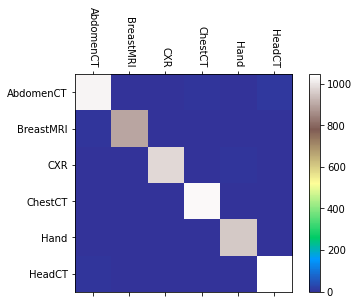

In [16]:
from sklearn.metrics import confusion_matrix
cmat = confusion_matrix(y_true, y_pred)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion_matrix(y_true, y_pred), cmap="terrain", interpolation='nearest')
fig.colorbar(cax)

ax.set_xticklabels(['']+class_names, rotation=270)
ax.set_yticklabels(['']+class_names)

plt.show()